In [196]:
import numpy as np
from numpy import random

In [197]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter

In [198]:
import pandas as pd

In [199]:
import math

In [200]:
from scipy.stats import bernoulli

In [201]:
from statsmodels.distributions.empirical_distribution import ECDF

In [202]:
from queue import PriorityQueue

class ReversePriorityQueue(PriorityQueue):
    def put(self, tup):
        newtup = tup[0] * -1, tup[1]
        PriorityQueue.put(self, newtup)
    def get(self):
        tup = PriorityQueue.get(self)
        newtup = tup[0] * -1, tup[1]
        return newtup

In [203]:
def Sampling_from_Bernoulli(num_items, num_samples):
    mean_values = np.random.uniform(0.0, 1.0, num_items)
    samples = np.array([bernoulli.rvs(mean_values[i], size=num_samples) for i in range(num_items)])
    samples_for_evaluation = np.array([bernoulli.rvs(mean_values[i], size=50000) for i in range(num_items)])
    return mean_values, samples, samples_for_evaluation

In [204]:
def Sampling_from_Exponential(num_items, num_samples):
    mean_values = np.random.uniform(0.0, 1.0, num_items)
    samples = np.array([random.exponential(mean_values[i], num_samples) for i in range(num_items)])
    samples_for_evaluation = np.array([random.exponential(mean_values[i], 50000) for i in range(num_items)])
    return mean_values, samples, samples_for_evaluation

In [205]:
def Sampling_from_Pareto(num_items, num_samples, parameter):
    mean_values = np.random.uniform(0.0, 1.0, num_items)
    a = parameter
    samples = np.array([(random.pareto(a, num_samples)+1)*(mean_values[i]*(a-1)/a) for i in range(num_items)])
    samples_for_evaluation = np.array([random.exponential(mean_values[i], 50000) for i in range(num_items)])
    return mean_values, samples, samples_for_evaluation

In [206]:
def costs_linear_in_means(num_items, budget, mean_values, base_price, coefficient):
    return np.array([min(budget, i) for i in coefficient*mean_values + base_price])

In [207]:
def costs_independent_from_means(num_items, budget, base_price, coefficient):
    mean_values = np.random.uniform(0.0, 1.0, num_items)
    return np.array([min(budget, i) for i in coefficient*mean_values + base_price])

In [208]:
def sample_means(samples):
    num_items = np.shape(samples)[0]
    num_samples = np.shape(samples)[1]
    return [np.sum(samples[i][:])/num_samples for i in range(num_items)]

In [209]:
def compute_test_scores(costs, budget, samples, obj):
    num_items = len(costs)
    num_samples = len(samples[0])
    test_scores = np.zeros(num_items)
    for i in range(num_items):
        num_tests = math.floor(budget / costs[i])
        num_batches = math.floor(num_samples / num_tests)
        temp_sum = 0
        for j in range(num_batches):
            if obj == "modular":
                temp_sum += np.sum(samples[i][j*num_tests:(j+1)*num_tests])
            elif obj == "square_root":
                temp_sum += math.sqrt(np.sum(samples[i][j*num_tests:(j+1)*num_tests]))
            elif obj == "max":
                temp_sum += np.max(samples[i][j*num_tests:(j+1)*num_tests])
            elif obj[0:4] == "top-":
                r = int(obj[4])
                temp_sum += np.sum(np.sort(samples[i][j*num_tests:(j+1)*num_tests])[-r:])
            elif obj[0:4] == "CES-":
                r = int(obj[4])
                temp_sum += np.power(np.sum(np.power(samples[i][j*num_tests:(j+1)*num_tests], r)), 1/r)
            #elif obj == "success_probability"
        test_scores[i] = temp_sum / num_batches
    return test_scores        

In [210]:
def evaluate_function_value(items, samples, obj):
    num_itmes = len(items)
    num_samples = np.shape(samples)[1]
    temp_sum = 0
    for j in range(num_samples):
        if obj == "modular":
            temp_sum += np.sum(samples[items,j])
        elif obj == "square_root":
            temp_sum += math.sqrt(np.sum(samples[items,j]))
        elif obj == "max":
            temp_sum += np.max(samples[items,j])
        elif obj[0:4] == "top-":
            r = int(obj[4])
            temp_sum += np.sum(np.sort(samples[items,j])[-r:])
        elif obj[0:4] == "CES-":
            r = int(obj[4])
            temp_sum += np.power(np.sum(np.power(samples[items,j], r)), 1/r)       
        #elif obj == "success_probability"
    return temp_sum / num_samples

In [211]:
def out_of_sample_value(items, distribution, mean_values, obj):
    num_items = len(items)
    num_samples = 50000
    if distribution == "Bernoulli":
        samples = np.array([bernoulli.rvs(mean_values[i], size=num_samples) for i in items])
        return evaluate_function_value(range(num_items), samples, obj)
    return

In [212]:
def test_score_algorithm(costs, budget, samples, obj):
    num_items = len(costs)
    test_scores = compute_test_scores(costs, budget, samples, obj)
    ranking = np.argsort(-test_scores)
    set_1 = np.array([], int)
    cost_for_1 = 0
    i = 0
    while cost_for_1 + costs[ranking[i]] <= budget:
        set_1 = np.append(set_1, ranking[i])
        cost_for_1 += costs[ranking[i]]
        i += 1
    cutoff = i
    #print(set_1, "\t\tThe first k items")
    for j in range(num_items-cutoff-1):
        if cost_for_1 + costs[ranking[j+cutoff+1]] <= budget:
            set_1 = np.append(set_1, ranking[j+cutoff+1])
            cost_for_1 += costs[ranking[j+cutoff+1]]
    #print(set_1, "\t\tS*: the first k items and more items greedily packed")
    
    set_2 = np.array([ranking[cutoff]])
    cost_for_2 = costs[ranking[cutoff]]
    for j in range(num_items):
        if j != cutoff and cost_for_2 + costs[ranking[j]] <= budget:
            set_2 = np.append(set_2, ranking[j])
            cost_for_2 += costs[ranking[j]]
    #print(set_2, "\t\tS**")
    
    set_1_value = evaluate_function_value(set_1, samples, obj)
    set_2_value = evaluate_function_value(set_2, samples, obj)
    if set_1_value >= set_2_value:
        return np.sort(set_1)
    else:
        return np.sort(set_2)

In [213]:
def test_score_algorithm_variant(costs, budget, samples, obj):
    num_items = len(costs)
    test_scores = compute_test_scores(costs, budget, samples, obj)
    ranking = np.argsort(-test_scores)
    set_1 = np.array([], int)
    cost_for_1 = 0
    i = 0
    while cost_for_1 + costs[ranking[i]] <= budget:
        set_1 = np.append(set_1, ranking[i])
        cost_for_1 += costs[ranking[i]]
        i += 1
    cutoff = i
    #print(set_1, "\t\tThe first k items")
    for j in range(num_items-cutoff-1):
        if cost_for_1 + costs[ranking[j+cutoff+1]] <= budget:
            set_1 = np.append(set_1, ranking[j+cutoff+1])
            cost_for_1 += costs[ranking[j+cutoff+1]]
    #print(set_1, "\t\tS*: the first k items and more items greedily packed")
    
    set_2 = np.array([ranking[cutoff]])
    cost_for_2 = costs[ranking[cutoff]]
    for j in range(num_items):
        if j != cutoff and cost_for_2 + costs[ranking[j]] <= budget:
            set_2 = np.append(set_2, ranking[j])
            cost_for_2 += costs[ranking[j]]
    #print(set_2, "\t\tS**")
    
    test_scores_unit_single = compute_test_scores(np.ones(num_items), budget, samples, obj)
    max_index = np.argmax(test_scores_unit_single)
    set_3 = np.array([max_index], int)
    cost_for_3 = costs[max_index]
    test_scores_unit_multiple = compute_test_scores(np.full(num_items, np.max(costs)), budget, samples, obj)
    ranking_multiple = np.argsort(-test_scores_unit_multiple)
    for j in range(num_items):
        if j != max_index and cost_for_3 + costs[ranking[j]] <= budget:
            set_3 = np.append(set_3, ranking[j])
            cost_for_3 += costs[ranking[j]]
    #print(set_3, "\t\tS***")
    #print(budget - cost_for_3)
    
    set_1_value = evaluate_function_value(set_1, samples, obj)
    set_2_value = evaluate_function_value(set_2, samples, obj)
    set_3_value = evaluate_function_value(set_3, samples, obj)
    output_ranking = np.argsort(-np.array([set_1_value, set_2_value, set_3_value]))
    if output_ranking[0] == 0:
        return np.sort(set_1)
    elif output_ranking[0] == 1:
        return np.sort(set_2)
    else:
        return set_3

In [214]:
def basic_greedy(costs, budget, samples, obj):
    num_items = len(costs)
    set_1 = np.array([], int)
    set_2 = np.array([], int)
    cost_for_1 = 0
    cost_for_2 = 0
    set_1_value = 0
    set_2_value = 0
    
    cutoff = -1
    cutoff_found = 0
    while not cutoff_found:
        max_index = -1
        max_marginal_return_per_cost = 0
        new_set_1_value = set_1_value
        for i in [(i) for i in range(num_items) if i not in set_1]:
            value_after_adding_i = evaluate_function_value(np.append(set_1, i), samples, obj)
            marginal_return_per_cost = max((value_after_adding_i - set_1_value) / costs[i], 0)
            if marginal_return_per_cost >= max_marginal_return_per_cost:
                max_index = i
                max_marginal_return_per_cost = marginal_return_per_cost
                new_set_1_value = value_after_adding_i
        if cost_for_1 + costs[max_index] <= budget:
            set_1 = np.append(set_1, max_index)
            set_1_value = new_set_1_value
            cost_for_1 += costs[max_index]
        else:
            cutoff_found = 1
            cutoff = max_index
            set_2 = np.append(set_2, max_index)
            set_2_value = evaluate_function_value(set_2, samples, obj)
            cost_for_2 = costs[max_index]
    #print(set_1, "\t\tthe items greedily packed until finding the first item that does not fit")
    #print(cutoff)
    
    enough_budget_for_1 = 1
    while enough_budget_for_1:
        max_index = -1
        max_marginal_return_per_cost = 0
        new_set_1_value = set_1_value
        for i in [(i) for i in range(num_items) if i not in set_1 and cost_for_1 + costs[i] <= budget]:
            value_after_adding_i = evaluate_function_value(np.append(set_1, i), samples, obj)
            marginal_return_per_cost = max((value_after_adding_i - set_1_value) / costs[i], 0)
            if marginal_return_per_cost >= max_marginal_return_per_cost:
                max_index = i
                max_marginal_return_per_cost = marginal_return_per_cost
                new_set_1_value = value_after_adding_i
        if max_index == -1:
            enough_budget_for_1 = 0
        else:
            set_1 = np.append(set_1, max_index)
            set_1_value = new_set_1_value
            cost_for_1 += costs[max_index]
    #print(np.sort(set_1), "\t\tthe items greedily packed and more items packed")
    
    enough_budget_for_2 = 1
    while enough_budget_for_2:
        max_index = -1
        max_marginal_return_per_cost = 0
        new_set_2_value = set_2_value
        for i in [(i) for i in range(num_items) if i not in set_2 and cost_for_2 + costs[i] <= budget]:
            value_after_adding_i = evaluate_function_value(np.append(set_2, i), samples, obj)
            marginal_return_per_cost = max((value_after_adding_i - set_2_value) / costs[i], 0)
            if marginal_return_per_cost >= max_marginal_return_per_cost:
                max_index = i
                max_marginal_return_per_cost = marginal_return_per_cost
                new_set_2_value = value_after_adding_i
        if max_index == -1:
            enough_budget_for_2 = 0
        else:
            set_2 = np.append(set_2, max_index)
            set_2_value = new_set_2_value
            cost_for_2 += costs[max_index]
    #print(np.sort(set_2), "\t\tthe first item that did not fit and more items greedily packed")
    
    if set_1_value >= set_2_value:
        return np.sort(set_1)
    else:
        return np.sort(set_2)

In [215]:
def lazy_greedy_update(costs, budget, samples, obj, start_set, start_cost, start_value, set_type):
    num_items = len(costs)
    output = start_set
    cost = start_cost
    value = start_value
    
    marginal_values = ReversePriorityQueue()
    for i in range(num_items):
        value_after_adding_i = evaluate_function_value(np.append(output, i), samples, obj)
        marginal_values.put(((value_after_adding_i-value)/costs[i], i))
    status = np.array([("updated") for i in range(num_items)], dtype='<U16') # assumption: costs[i]<=budget for all i
    for i in range(num_items):
        if start_cost + costs[i] > budget or i in start_set:
            status[i] = "removed"
    
    while not marginal_values.empty():
        (max_marginal_return, max_index) = marginal_values.get()
        if status[max_index] == "not_updated":
            new_value = evaluate_function_value(np.append(output, max_index), samples, obj)
            new_marginal_return = max(new_value - value, 0)
            marginal_values.put((new_marginal_return/costs[max_index], max_index))
            status[max_index] = "updated"
        elif status[max_index] == "updated":
            if set_type == 0 and cost + costs[max_index] > budget:
                    return output, cost, value, max_index
            else:
                cost += costs[max_index]
                output = np.append(output, max_index)
                value = evaluate_function_value(output, samples, obj)
                status[max_index] == "removed"
            for i in [(i) for i in range(num_items) if status[i] != "removed"]:
                status[i] = "not_updated"
                if set_type != 0 and cost + costs[i] > budget:
                    status[i] = "removed"
    
    return output, value

In [216]:
def lazy_greedy(costs, budget, samples, obj):
    first_set, first_cost, first_value, cutoff = lazy_greedy_update(costs, budget, samples, obj, np.array([], int), 0, 0, 0)
    set_1, set_1_value = lazy_greedy_update(costs, budget, samples, obj, first_set, first_cost, first_value, 1)
    second_set = np.array([cutoff])
    second_value = evaluate_function_value(second_set, samples, obj)
    set_2, set_2_value = lazy_greedy_update(costs, budget, samples, obj, second_set, costs[cutoff], second_value, 2)
    #print(np.sort(set_1))
    #print(np.sort(set_2))
    if set_1_value >= set_2_value:
        return np.sort(set_1)
    else:
        return np.sort(set_2)
    return

In [217]:
def lazy_forward(costs, budget, samples, obj, cost_type):
    num_items = len(costs)
    output = np.array([], int)
    cost = 0
    value = 0
    
    marginal_values = ReversePriorityQueue()
    for i in range(num_items):
        value_i = evaluate_function_value(np.array([i]), samples, obj)
        if cost_type == "unit":
            marginal_values.put((value_i, i))
        elif cost_type == "general":
            marginal_values.put((value_i/costs[i], i))
    status = np.array([("updated") for i in range(num_items)], dtype='<U16') # assumption: costs[i]<=budget for all i
    
    while not marginal_values.empty():
        (max_marginal_return, max_index) = marginal_values.get()
        if status[max_index] == "not_updated":
            new_value = evaluate_function_value(np.append(output, max_index), samples, obj)
            new_marginal_return = max(new_value - value, 0)
            if cost_type == "unit":
                marginal_values.put((new_marginal_return, max_index))
            elif cost_type == "general":
                marginal_values.put((new_marginal_return/costs[max_index], max_index))
            status[max_index] = "updated"
        elif status[max_index] == "updated":
            cost += costs[max_index]
            output = np.append(output, max_index)
            value = evaluate_function_value(output, samples, obj)
            status[max_index] == "removed"
            for i in [(i) for i in range(num_items) if status[i] != "removed"]:
                if cost + costs[i] > budget:
                    status[i] = "removed"
                else:
                    status[i] = "not_updated"
    
    #print(budget-cost)
    return output, value

In [218]:
def cost_effective_lazy_forward_KDD(costs, budget, samples, obj):
    set_unit_cost, set_unit_cost_value = lazy_forward(costs, budget, samples, obj, "unit")
    set_general_cost, set_general_cost_value = lazy_forward(costs, budget, samples, obj, "general")
    #print(np.sort(set_unit_cost))
    #print(np.sort(set_general_cost))
    if set_unit_cost_value >= set_general_cost_value:
        return set_unit_cost
    else:
        return np.sort(set_general_cost)
    return np.sort(set_general_cost)

In [219]:
def create_output_files():
    column_labels_raw = ['obj', 'distribution', 'avg_cost', 'budget', 'avg_cost_normalized', 'num_setups', 
                         'test_number', 'num_reps', 'num_items', 'num_samples',  'ratio']
    df_raw = pd.DataFrame(columns=column_labels_raw)
    df_raw.to_csv('results_raw_data.csv', index=False)
    
    column_labels_summary = ['obj', 'distribution', 'avg_cost', 'budget', 'avg_cost_normalized', 'num_setups', 'num_reps',
                             'num_items', 'num_samples','mean_ratio', 'std','25%-quantile', 'median', '75%-quantile']
    df_summary = pd.DataFrame(columns=column_labels_summary)
    df_summary.to_csv('results_summary.csv', index=False)

In [220]:
def test_linear_cost(num_items, num_samples, distribution, obj, budget, num_setups, num_reps, correlation):
    if correlation == 0:
        df = pd.read_csv('independent cost/results_raw_data.csv')
    else:
        df = pd.read_csv('correlated cost/results_raw_data.csv')
    
    for i in range(num_setups):
        base_price = 1
        coeff = i*budget/num_setups
        avg_cost = 1 + coeff*0.5
        for j in range(num_reps):
            if distribution == "Bernoulli":
                mean_values, samples, samples_for_evaluation = Sampling_from_Bernoulli(num_items, num_samples)        
            elif distribution == "Exponential":
                mean_values, samples, samples_for_evaluation = Sampling_from_Exponential(num_items, num_samples)
            elif distribution[0:7] == "Pareto-":
                a = float(distribution[7:11])
                mean_values, samples, samples_for_evaluation = Sampling_from_Pareto(num_items, num_samples, a)

            if correlation == 0:
                costs = costs_independent_from_means(num_items, budget, base_price, coeff)
            else:
                costs = costs_linear_in_means(num_items, budget, mean_values, base_price, coeff)
            
            #output_TSG = test_score_algorithm(costs, budget, samples, obj)
            output_TSG = test_score_algorithm(costs, budget, samples, obj)
            value_TSG = evaluate_function_value(output_TSG, samples_for_evaluation, obj)
            output_CELF = cost_effective_lazy_forward_KDD(costs, budget, samples, obj)
            value_CELF = evaluate_function_value(output_CELF, samples_for_evaluation, obj)
            df = df.append({'obj': obj, 'distribution': distribution, 'avg_cost': avg_cost, 'budget': budget, 
                            'avg_cost_normalized': avg_cost/budget,'num_setups': num_setups,'test_number': j+1, 
                            'num_reps': num_reps, 'num_items': num_items, 'num_samples': num_samples, 
                            'ratio': value_TSG/value_CELF}, ignore_index = True)
    #print(df)        
    df.to_csv('results_raw_data.csv', index=False)
    if correlation == 0:
        df.to_csv('independent cost/results_raw_data.csv', index=False)
    else:
        df.to_csv('correlated cost/results_raw_data.csv', index=False)

In [221]:
def draw_boxplot(num_items, num_samples, distribution, obj, budget, num_setups, num_reps):
    df = pd.read_csv('results_raw_data.csv')
    filt1 = (df['obj'] == obj) & (df['distribution'] == distribution) & (df['num_items'] == num_items) 
    filt2 = (df['num_samples'] == num_samples) & (df['budget'] == budget)
    filt3 = (df['num_setups'] == num_setups) & (df['num_reps'] == num_reps)
    filtered = df[filt1 & filt2 & filt3]
    filtered.boxplot(column = 'ratio', by = 'avg_cost')
    plt.title('')
    plt.suptitle('')
    plt.xlabel("average cost normalized")
    plt.ylabel("TSG / CELF")
    plt.ylim((0.5,1.5))

In [222]:
def boxplot_first(num_items, num_samples, distribution, objs, budget, num_setups, num_reps, correlation):
    if correlation == 0:
        df = pd.read_csv('independent cost/results_raw_data.csv')
    else:
        df = pd.read_csv('correlated cost/results_raw_data.csv')
    filt1 = (df['num_samples'] == num_samples) & (df['distribution'] == distribution) & (df['num_items'] == num_items) 
    filt2 = (df['budget'] == budget) & (df['num_setups'] == num_setups) & (df['num_reps'] == num_reps)
    num_axes = len(objs)
    
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    flierprops = dict(marker='o', markeredgecolor='lightgrey')
    for count, obj in enumerate(objs):
        filtered = df[filt1 & filt2 & (df['obj'] == obj)]
        filtered.boxplot(ax = axes[count], column = 'ratio', by = 'avg_cost', flierprops=flierprops)
        axes[count].set_title(obj)
        axes[count].set_xlabel("average cost")
        axes[count].set_ylabel("TSG / CELF")
        axes[count].set_ylim((0.5, 1.5))
        axes[count].xaxis.set_minor_formatter(FormatStrFormatter('%.1f'))
    fig.suptitle(str(num_samples) + ' samples')

In [223]:
def boxplot_second(num_items, distribution, objs, budget, num_setups, num_reps, correlation):
    if correlation == 0:
        df = pd.read_csv('independent cost/results_raw_data.csv')
    else:
        df = pd.read_csv('correlated cost/results_raw_data.csv')
    filt1 = (df['distribution'] == distribution) & (df['num_items'] == num_items) 
    filt2 = (df['budget'] == budget) & (df['num_setups'] == num_setups) & (df['num_reps'] == num_reps)
    num_axes = len(objs)
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    flierprops = dict(marker='o', markeredgecolor='lightgrey')
    for count, obj in enumerate(objs):
        filtered = df[filt1 & filt2 & (df['obj'] == obj)]
        filtered.boxplot(ax = axes[count], column = 'ratio', by = 'num_samples', flierprops=flierprops)
        axes[count].set_title(obj)
        axes[count].set_xlabel("num samples")
        axes[count].set_ylabel("TSG / CELF")
        axes[count].set_ylim((0.5, 1.5))
    fig.suptitle('')

In [224]:
def plot_Empirical_CDF(num_items, sample_sizes, cost_values, distribution, objs, budget, num_setups, num_reps):
    df_c = pd.read_csv('correlated cost/results_raw_data.csv')
    df_uc = pd.read_csv('independent cost/results_raw_data.csv')
    
    filt1_c = (df_c['num_samples'].isin(sample_sizes)) & (df_c['avg_cost'].isin(cost_values))
    filt2_c = (df_c['obj'].isin(objs)) & (df_c['distribution'] == distribution) & (df_c['num_items'] == num_items) 
    filt3_c = (df_c['budget'] == budget) & (df_c['num_setups'] == num_setups) & (df_c['num_reps'] == num_reps)
    filt1_uc = (df_uc['num_samples'].isin(sample_sizes)) & (df_uc['avg_cost'].isin(cost_values))
    filt2_uc = (df_uc['obj'].isin(objs)) & (df_uc['distribution'] == distribution) & (df_uc['num_items'] == num_items) 
    filt3_uc = (df_uc['budget'] == budget) & (df_uc['num_setups'] == num_setups) & (df_uc['num_reps'] == num_reps)
    
    data_c = df_c[filt1_c & filt2_c & filt3_c]
    data_uc = df_uc[filt1_uc & filt2_uc & filt3_uc]
    
    ecdf_c = ECDF(data_c['ratio'])
    ecdf_uc = ECDF(data_uc['ratio'])
    plt.plot(ecdf_c.x, ecdf_c.y, label = 'Correlated costs')
    plt.plot(ecdf_uc.x, ecdf_uc.y, label = 'Uncorrelated costs')
    plt.xlim((0.5, 1.5))
    plt.legend(loc = 'lower right')
    plt.xlabel("TSG / CELF")
    plt.title('Empirical CDF')
    plt.grid()

In [225]:
def plot_Empirical_CDF_diff_objs(num_items, sample_sizes, cost_values, distribution, objs, budget, num_setups, num_reps):
    df_c = pd.read_csv('correlated cost/results_raw_data.csv')
    
    filt1_c = (df_c['num_samples'].isin(sample_sizes)) & (df_c['avg_cost'].isin(cost_values))
    filt2_c = (df_c['distribution'] == distribution) & (df_c['num_items'] == num_items) 
    filt3_c = (df_c['budget'] == budget) & (df_c['num_setups'] == num_setups) & (df_c['num_reps'] == num_reps)
    num_axes = len(objs)
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    for count, obj in enumerate(objs):
        data_c = df_c[filt1_c & filt2_c & filt3_c & (df_c['obj'] == obj)]
        ecdf_c = ECDF(data_c['ratio'])
        axes[count].plot(ecdf_c.x, ecdf_c.y, label = 'Correlated costs')
        axes[count].set_xlim((0.7, 1.3))
        axes[count].set_title(obj)
        axes[count].set_xlabel("TSG / CELF")
        axes[count].grid()
    fig.suptitle('Empirical CDF')

In [226]:
def plot_Empirical_PDF(num_items, sample_sizes, cost_values, distribution, objs, budget, num_setups, num_reps):
    df_c = pd.read_csv('correlated cost/results_raw_data.csv')
    df_uc = pd.read_csv('independent cost/results_raw_data.csv')
    
    filt1_c = (df_c['num_samples'].isin(sample_sizes)) & (df_c['avg_cost'].isin(cost_values))
    filt2_c = (df_c['obj'].isin(objs)) & (df_c['distribution'] == distribution) & (df_c['num_items'] == num_items) 
    filt3_c = (df_c['budget'] == budget) & (df_c['num_setups'] == num_setups) & (df_c['num_reps'] == num_reps)
    filt1_uc = (df_uc['num_samples'].isin(sample_sizes)) & (df_uc['avg_cost'].isin(cost_values))
    filt2_uc = (df_uc['obj'].isin(objs)) & (df_uc['distribution'] == distribution) & (df_uc['num_items'] == num_items) 
    filt3_uc = (df_uc['budget'] == budget) & (df_uc['num_setups'] == num_setups) & (df_uc['num_reps'] == num_reps)
    
    data_c = df_c[filt1_c & filt2_c & filt3_c]
    data_uc = df_uc[filt1_uc & filt2_uc & filt3_uc]
    fig, axes = plt.subplots(1, 2, figsize = (6.4*2, 4.8))
    axes[0].hist(data_c['ratio'], bins = 200)
    axes[1].hist(data_uc['ratio'], bins = 200, color = '#ff7f0e')
    for i in [0,1]:
        axes[i].set_ylabel("# of data")
        axes[i].set_xlabel("TSG / CELF")
        axes[i].set_ylim((0, 14000))
        axes[i].set_xlim((0.8, 1.2))
        axes[i].grid()
    axes[0].set_title("Correlated costs")
    axes[1].set_title("Uncorrelated costs")

In [256]:
def boxplot_summary(num_items, distributions, budget, num_setups, num_reps, correlation):
    if correlation == 0:
        df = pd.read_csv('independent cost/results_raw_data.csv')
    else:
        df = pd.read_csv('correlated cost/results_raw_data.csv')
    filt1 = (df['num_items'] == num_items) 
    filt2 = (df['budget'] == budget) & (df['num_setups'] == num_setups) & (df['num_reps'] == num_reps)
    num_axes = len(distributions)
    df['obj'] = df['obj'].replace(['CES-2'], 'mb')
    
    fig, axes = plt.subplots(1, num_axes, figsize = (6.4*num_axes, 4.8))
    flierprops = dict(marker='o', markeredgecolor='lightgrey')
    for count, distribution in enumerate(distributions):
        filtered = df[filt1 & filt2 & (df['distribution'] == distribution)]
        if distribution == 'Bernoulli':
            obj_order = list(['max', 'mb', 'modular'])
            filtered_again = df[df['obj'].isin(obj_order)]
            filtered_again.boxplot(ax = axes[count], column = 'ratio', by = 'obj', flierprops = flierprops)
            axes[count].set_xticklabels(['max', 'CES-2', 'modular'])
        else:
            filtered.boxplot(ax = axes[count], column = 'ratio', by = 'obj', flierprops = flierprops)
            axes[count].set_xticklabels(['max', 'CES-2', 'modular', 'square_root'])
        axes[count].set_title(distribution)
        axes[count].grid(b=True, which='major', linestyle='-')
        axes[count].set_xlabel("objectives")
        axes[count].set_ylabel("TSG / CELF")
        axes[count].set_ylim((0.5, 1.5)) 
    fig.suptitle('')

In [257]:
sample_sizes = [50, 100, 150, 200, 250]
cost_values = [1, 2.5, 4.0, 5.5, 7.0, 8.5, 10.0, 11.5, 13, 14.5]
objs = ['max', 'CES-2', 'modular', 'square_root']
objs_for_Bernoulli = ['max', 'CES-2', 'modular']

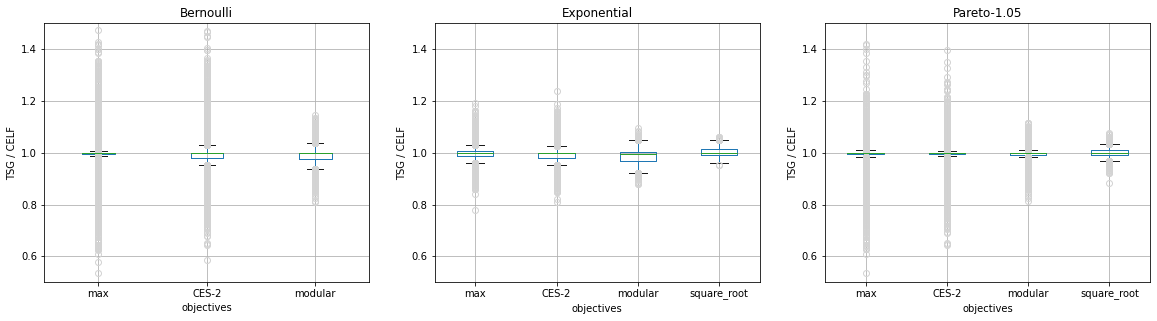

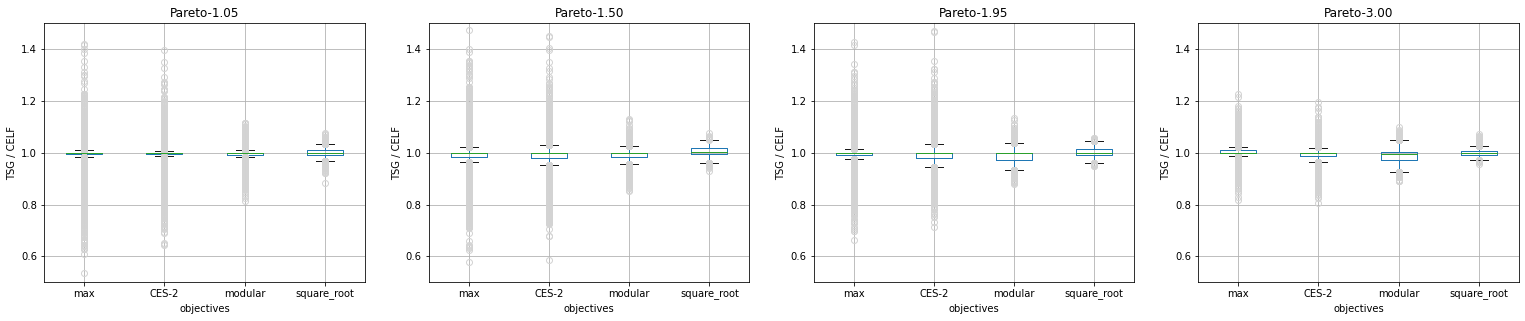

In [258]:
distributions1 = ["Bernoulli", "Exponential", "Pareto-1.05"]
distributions2 = ["Pareto-1.05", "Pareto-1.50", "Pareto-1.95", "Pareto-3.00"]
boxplot_summary(100, distributions1, 30, 10, 100, 1)
boxplot_summary(100, distributions2, 30, 10, 100, 1)

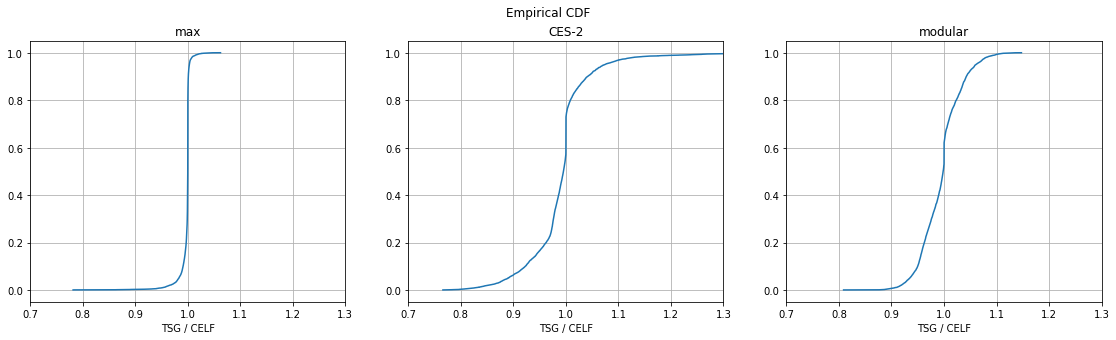

In [230]:
plot_Empirical_CDF_diff_objs(100, sample_sizes, cost_values, "Bernoulli", objs_for_Bernoulli, 30, 10, 100)

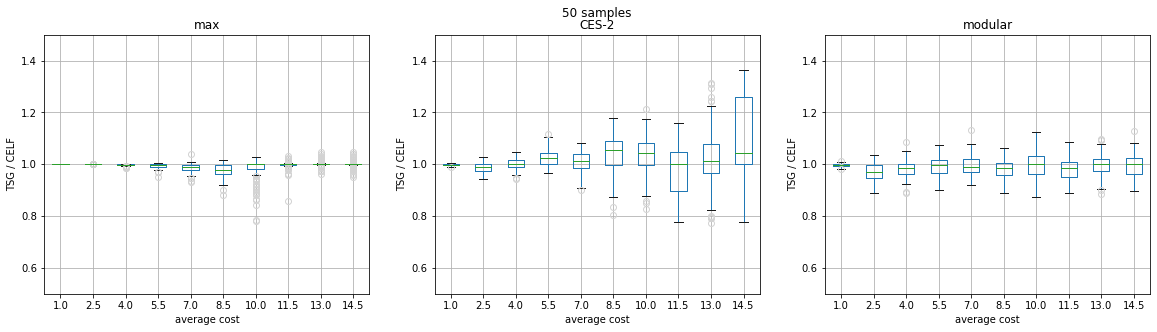

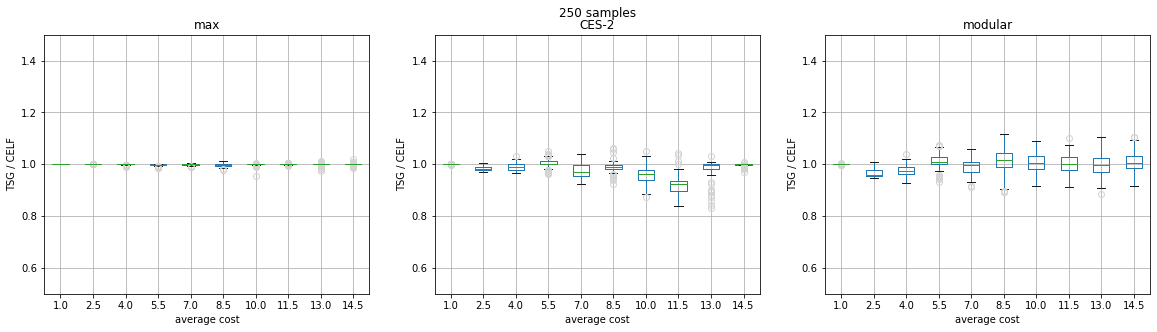

In [231]:
# correlated cost
boxplot_first(100, 50, "Bernoulli", objs_for_Bernoulli, 30, 10, 100, 1)
boxplot_first(100, 250, "Bernoulli", objs_for_Bernoulli, 30, 10, 100, 1)

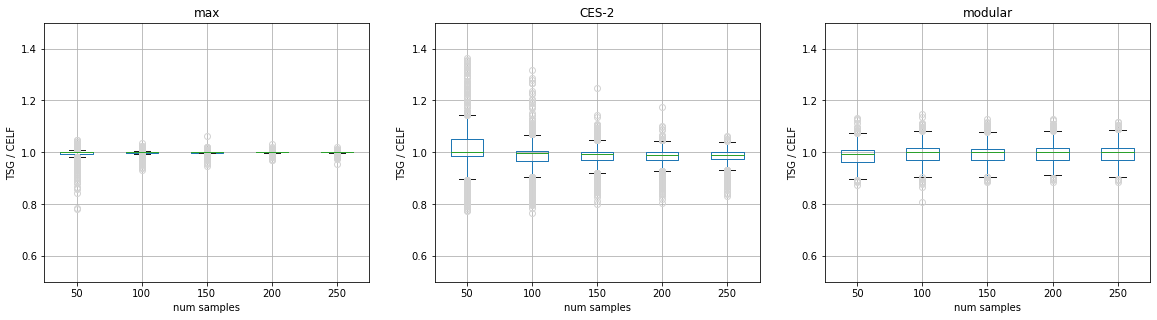

In [232]:
# correlated cost
boxplot_second(100, "Bernoulli", objs_for_Bernoulli, 30, 10, 100, 1)

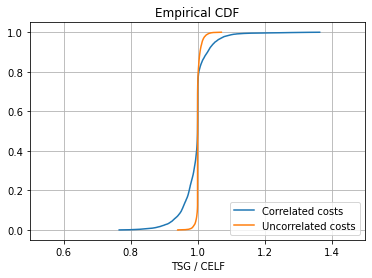

In [233]:
plot_Empirical_CDF(100, sample_sizes, cost_values, "Bernoulli", objs_for_Bernoulli, 30, 10, 100)

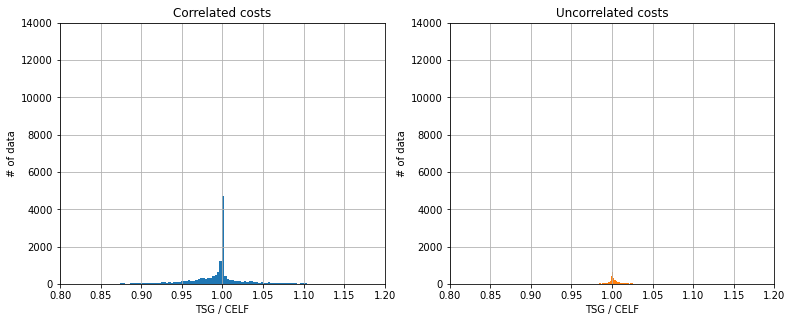

In [234]:
plot_Empirical_PDF(100, sample_sizes, cost_values, "Bernoulli", objs_for_Bernoulli, 30, 10, 100)

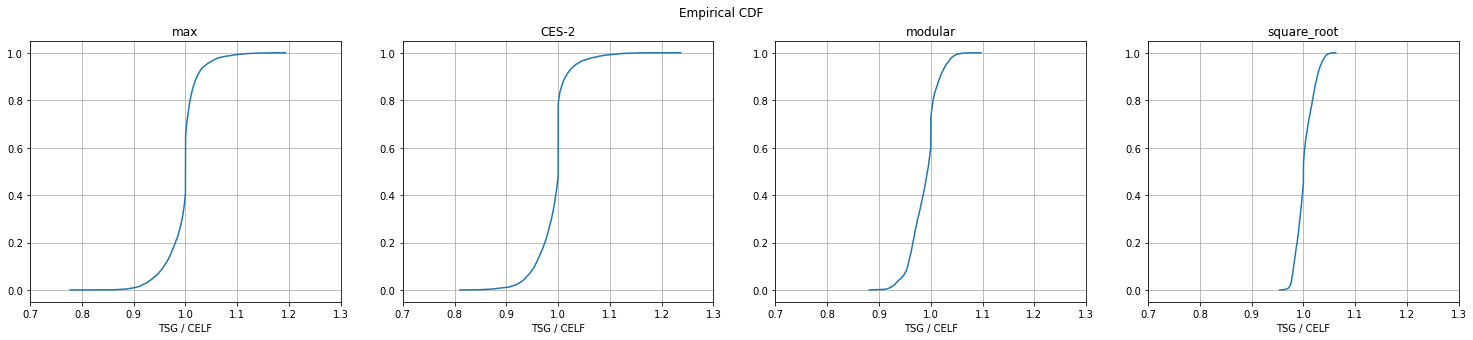

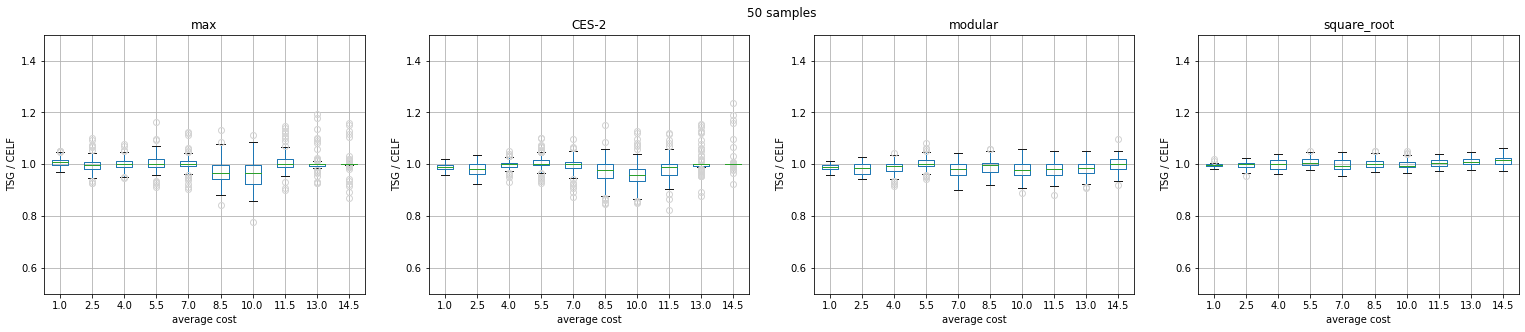

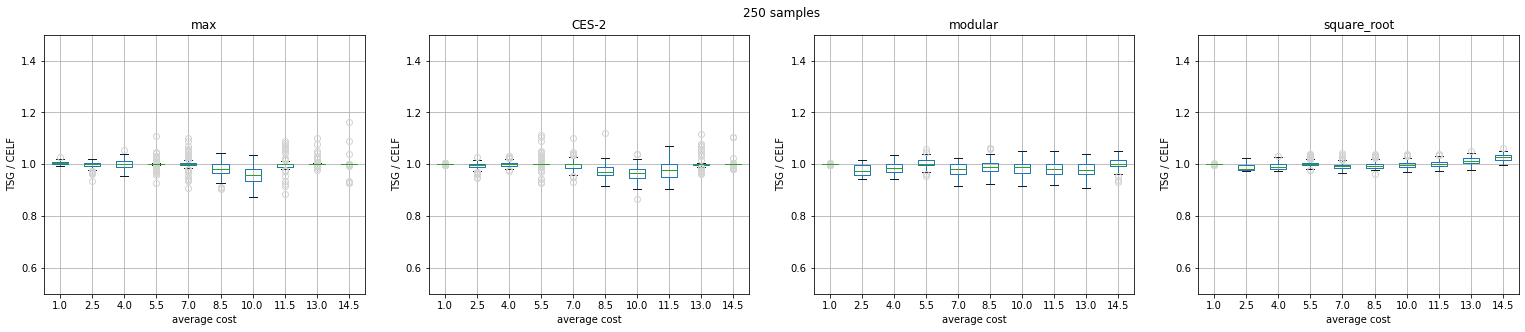

In [235]:
plot_Empirical_CDF_diff_objs(100, sample_sizes, cost_values, "Exponential", objs, 30, 10, 100)
boxplot_first(100, 50, "Exponential", objs, 30, 10, 100, 1)
boxplot_first(100, 250, "Exponential", objs, 30, 10, 100, 1)

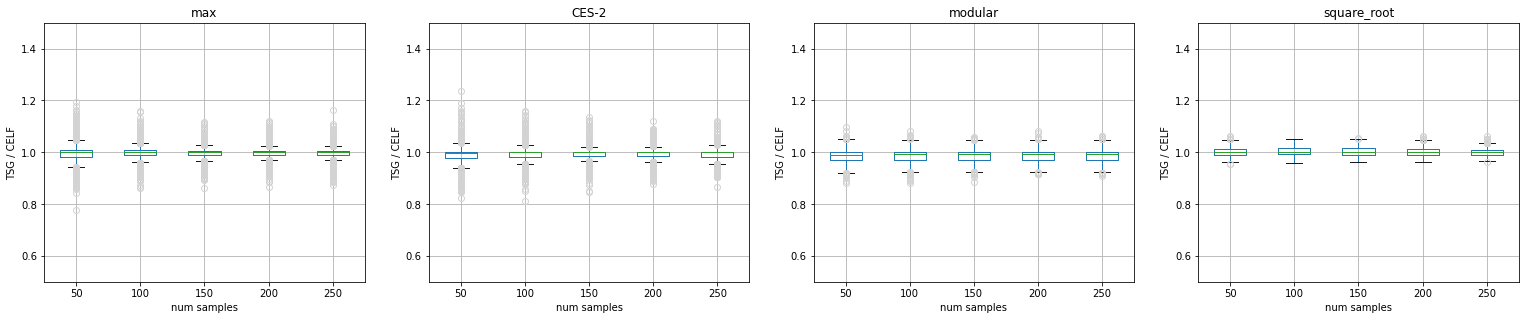

In [236]:
boxplot_second(100, "Exponential", objs, 30, 10, 100, 1)

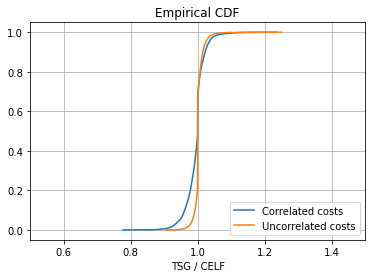

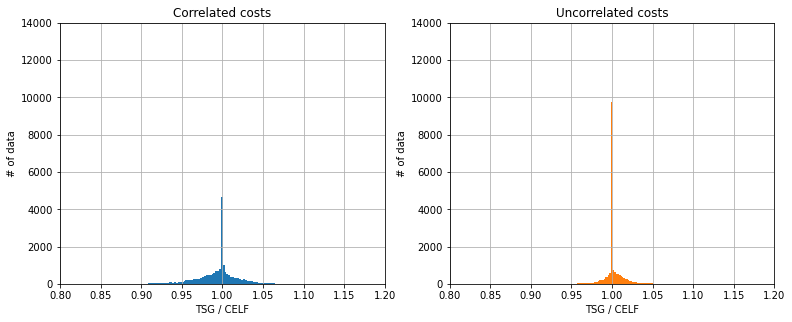

In [237]:
plot_Empirical_CDF(100, sample_sizes, cost_values, "Exponential", objs, 30, 10, 100)
plot_Empirical_PDF(100, sample_sizes, cost_values, "Exponential", objs, 30, 10, 100)

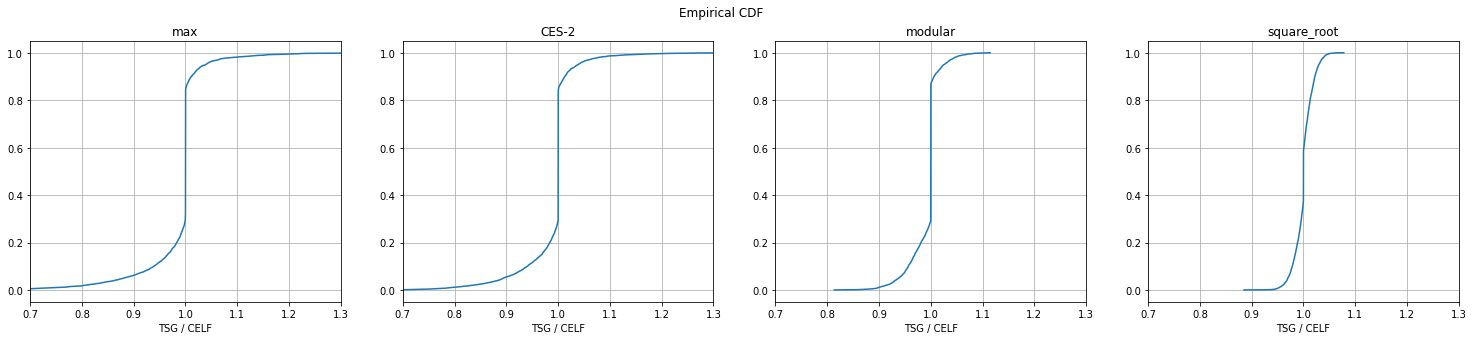

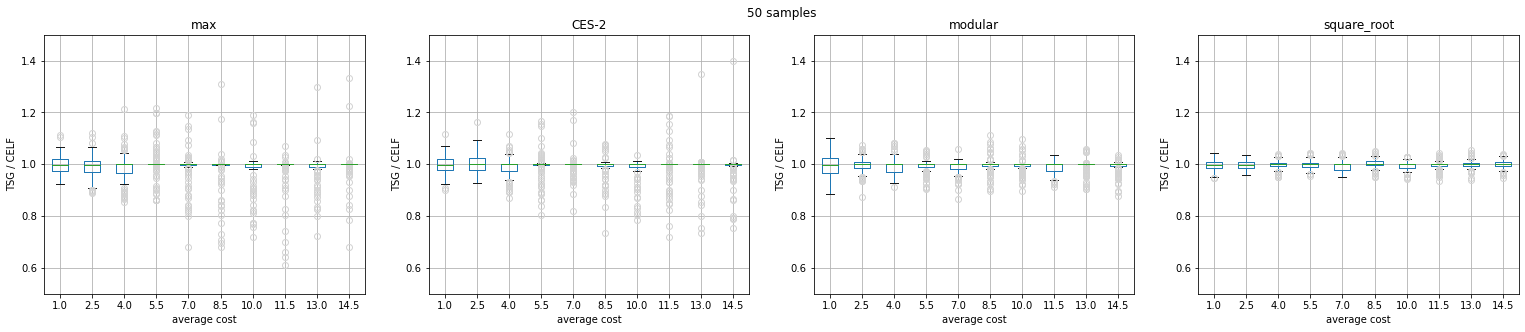

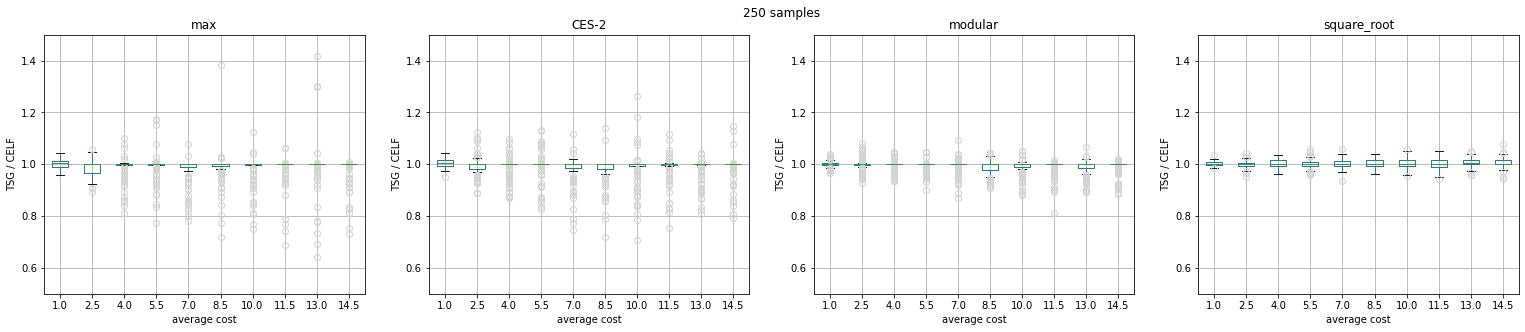

In [238]:
plot_Empirical_CDF_diff_objs(100, sample_sizes, cost_values, "Pareto-1.05", objs, 30, 10, 100)
boxplot_first(100, 50, "Pareto-1.05", objs, 30, 10, 100, 1)
boxplot_first(100, 250, "Pareto-1.05", objs, 30, 10, 100, 1)

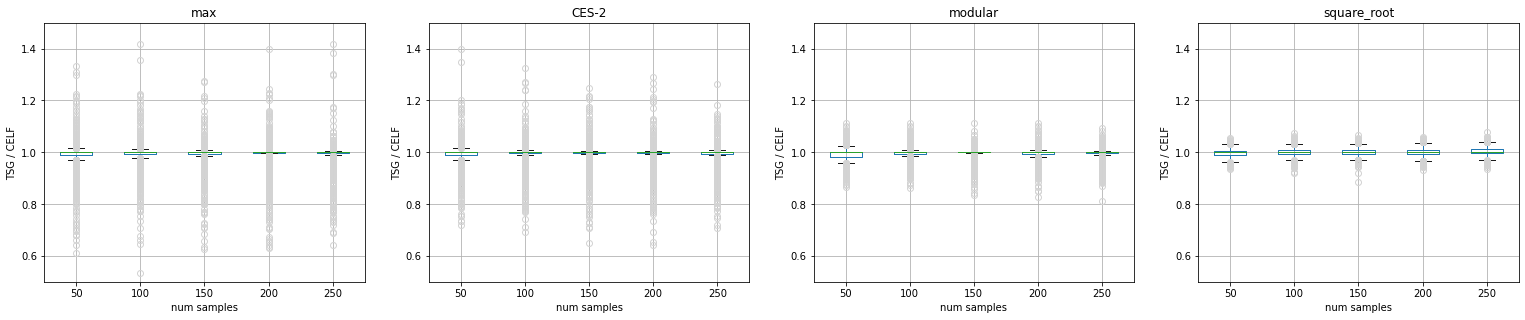

In [239]:
boxplot_second(100, "Pareto-1.05", objs, 30, 10, 100, 1)

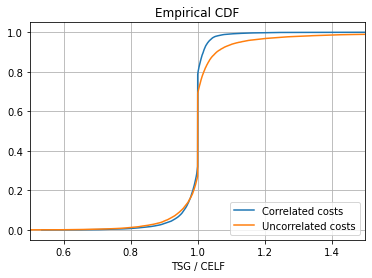

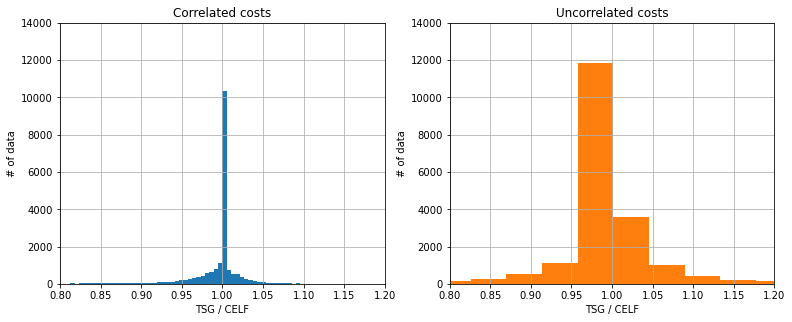

In [240]:
plot_Empirical_CDF(100, sample_sizes, cost_values, "Pareto-1.05", objs, 30, 10, 100)
plot_Empirical_PDF(100, sample_sizes, cost_values, "Pareto-1.05", objs, 30, 10, 100)

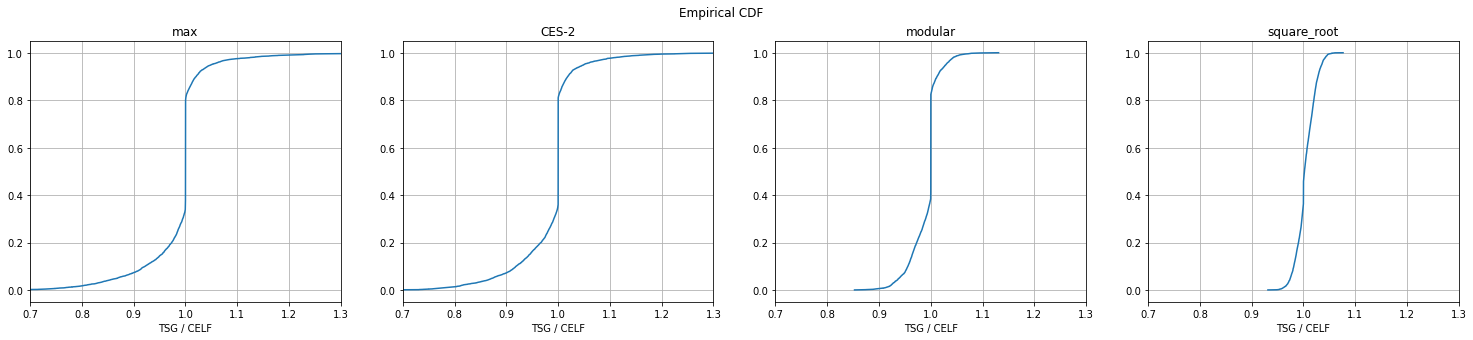

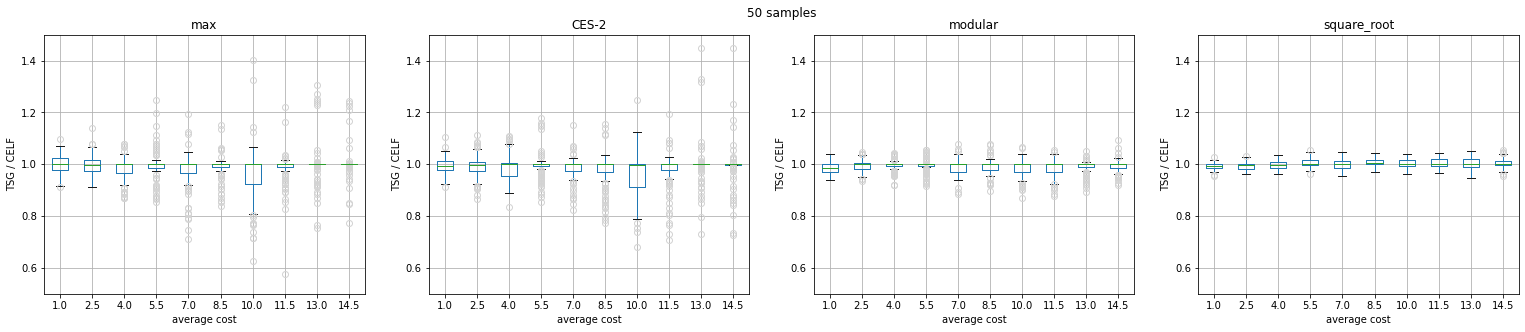

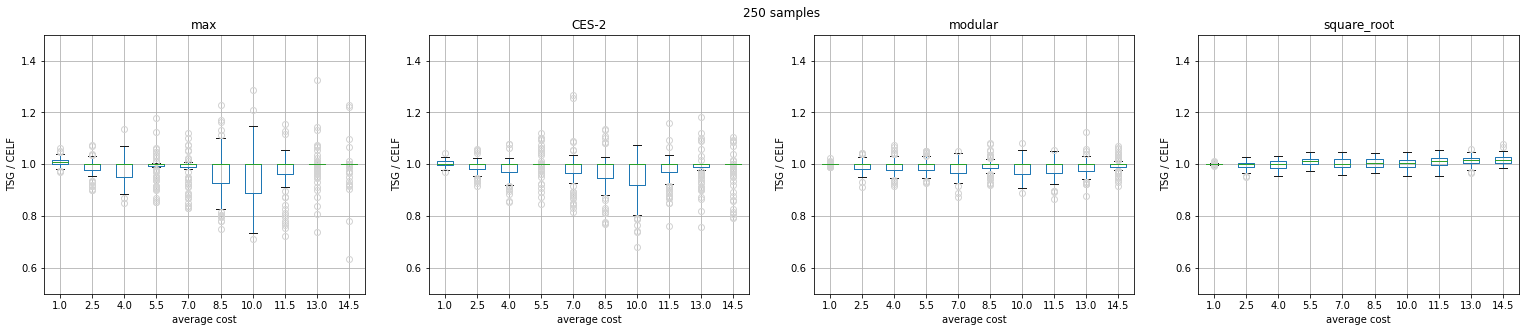

In [241]:
plot_Empirical_CDF_diff_objs(100, sample_sizes, cost_values, "Pareto-1.50", objs, 30, 10, 100)
boxplot_first(100, 50, "Pareto-1.50", objs, 30, 10, 100, 1)
boxplot_first(100, 250, "Pareto-1.50", objs, 30, 10, 100, 1)

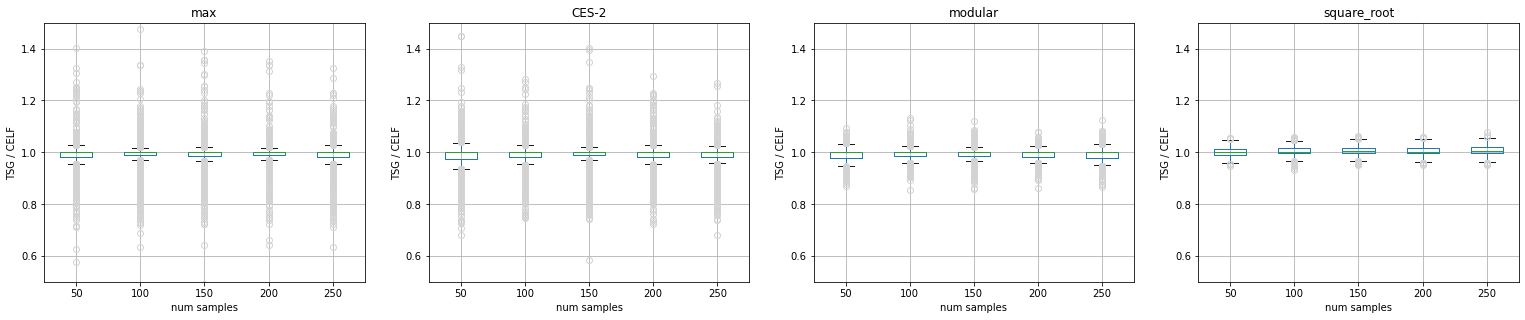

In [242]:
boxplot_second(100, "Pareto-1.50", objs, 30, 10, 100, 1)

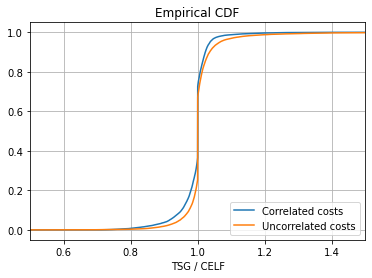

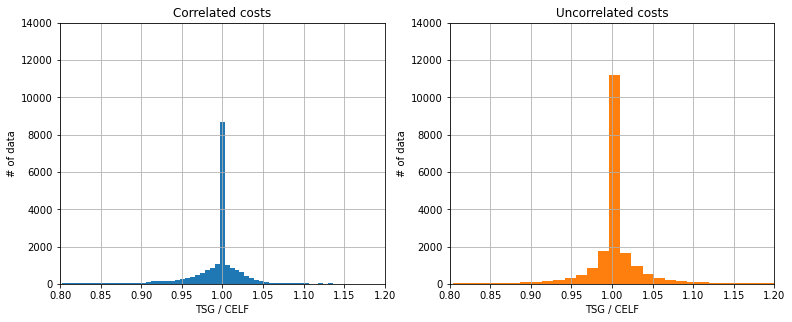

In [243]:
plot_Empirical_CDF(100, sample_sizes, cost_values, "Pareto-1.50", objs, 30, 10, 100)
plot_Empirical_PDF(100, sample_sizes, cost_values, "Pareto-1.50", objs, 30, 10, 100)

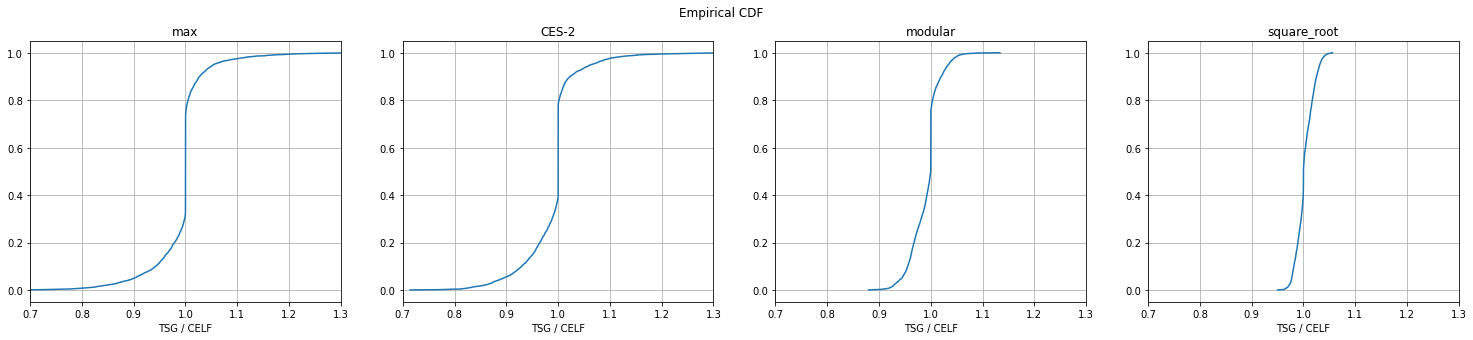

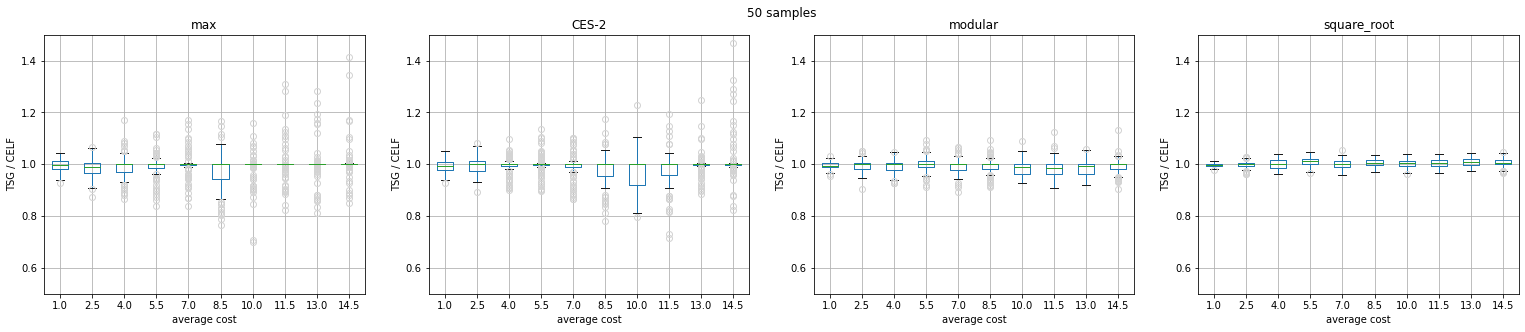

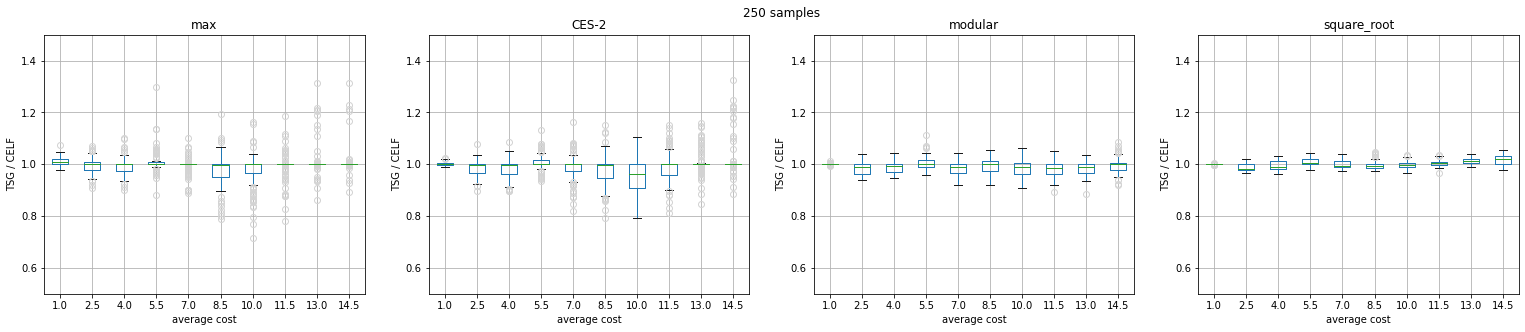

In [244]:
plot_Empirical_CDF_diff_objs(100, sample_sizes, cost_values, "Pareto-1.95", objs, 30, 10, 100)
boxplot_first(100, 50, "Pareto-1.95", objs, 30, 10, 100, 1)
boxplot_first(100, 250, "Pareto-1.95", objs, 30, 10, 100, 1)

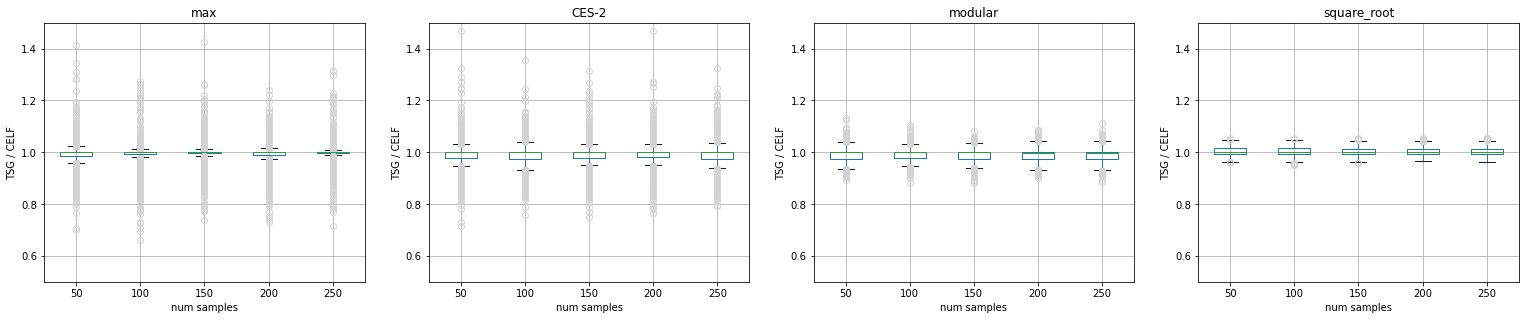

In [245]:
boxplot_second(100, "Pareto-1.95", objs, 30, 10, 100, 1)

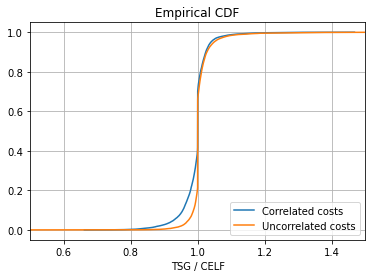

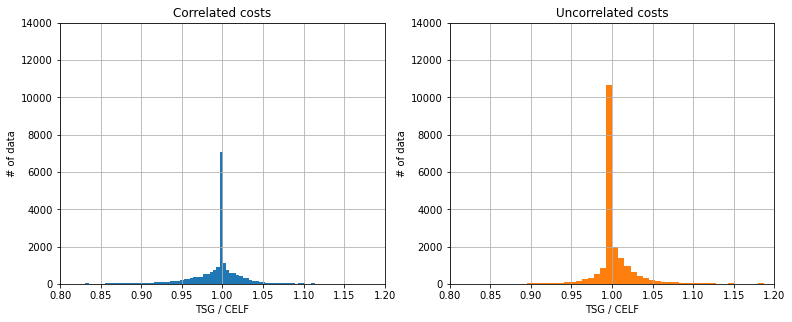

In [246]:
plot_Empirical_CDF(100, sample_sizes, cost_values, "Pareto-1.95", objs, 30, 10, 100)
plot_Empirical_PDF(100, sample_sizes, cost_values, "Pareto-1.95", objs, 30, 10, 100)

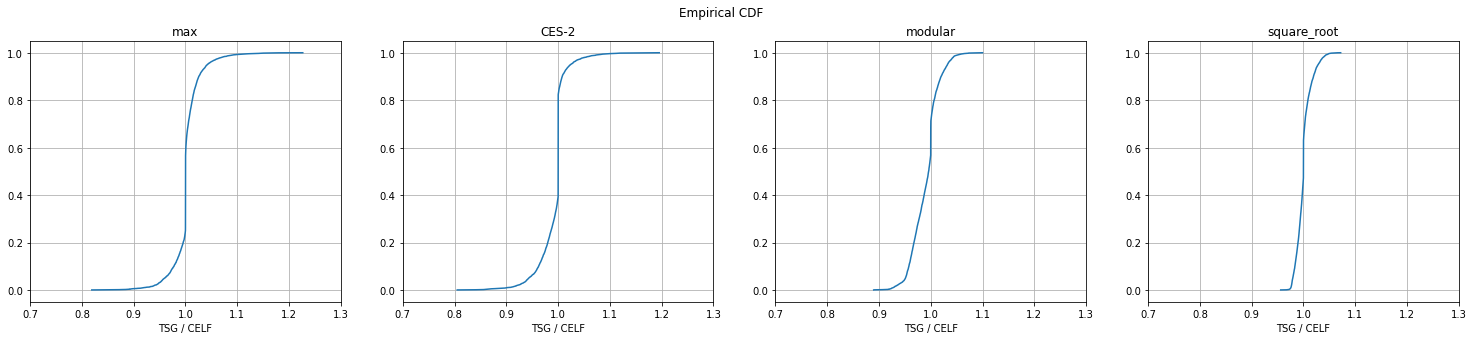

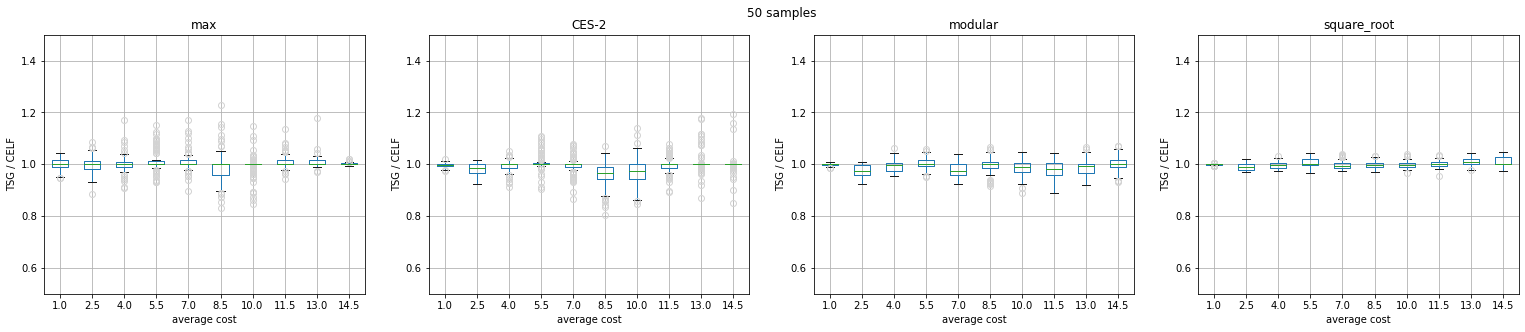

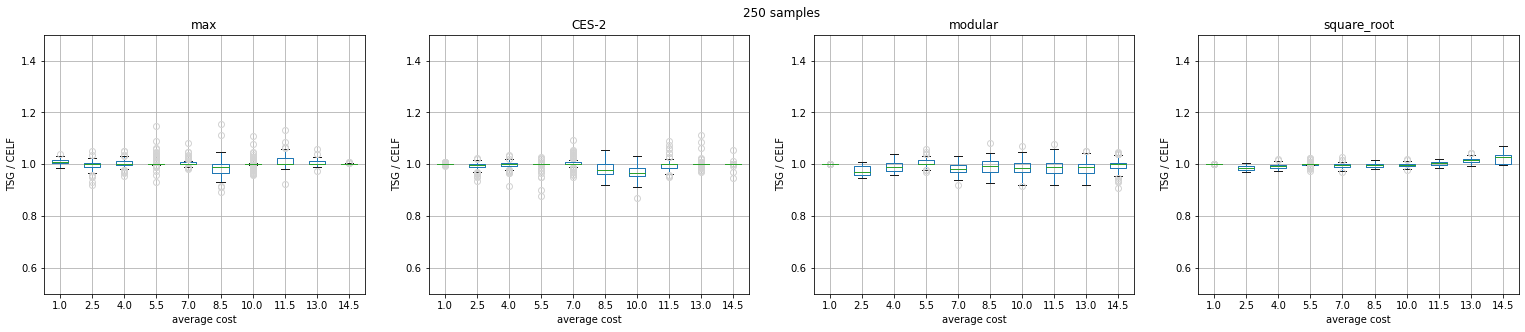

In [247]:
plot_Empirical_CDF_diff_objs(100, sample_sizes, cost_values, "Pareto-3.00", objs, 30, 10, 100)
boxplot_first(100, 50, "Pareto-3.00", objs, 30, 10, 100, 1)
boxplot_first(100, 250, "Pareto-3.00", objs, 30, 10, 100, 1)

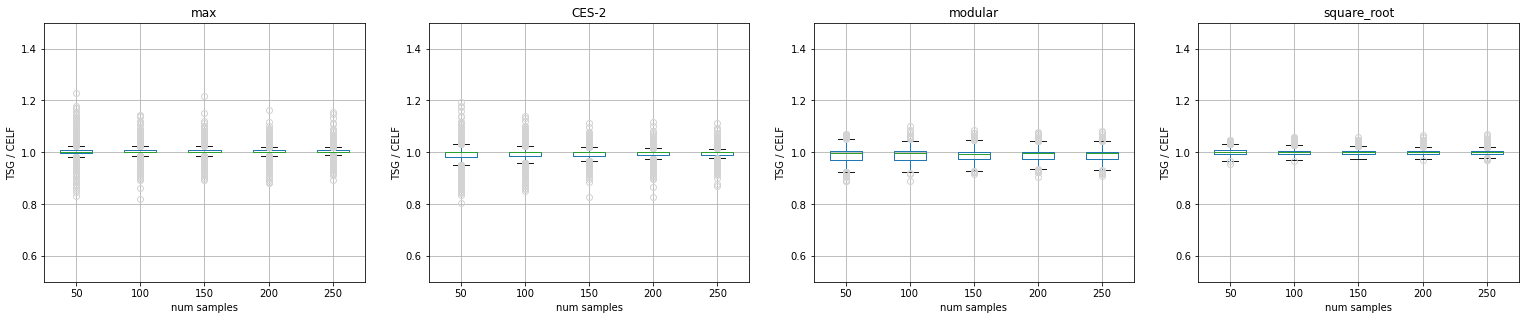

In [248]:
boxplot_second(100, "Pareto-3.00", objs, 30, 10, 100, 1)

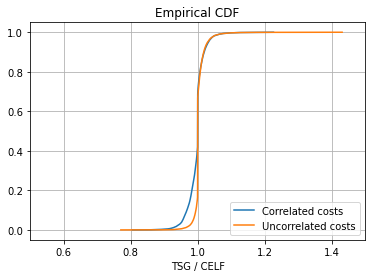

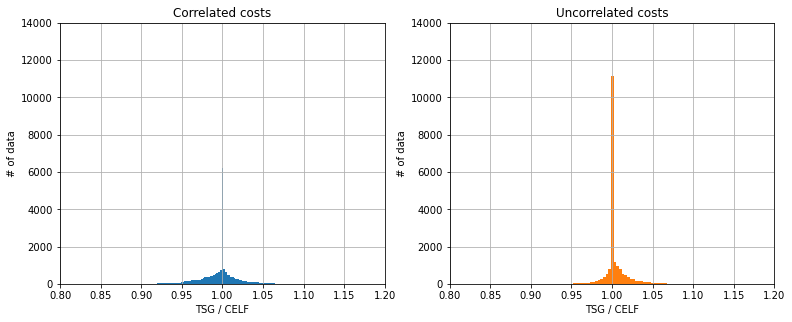

In [249]:
plot_Empirical_CDF(100, sample_sizes, cost_values, "Pareto-3.00", objs, 30, 10, 100)
plot_Empirical_PDF(100, sample_sizes, cost_values, "Pareto-3.00", objs, 30, 10, 100)